In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.decomposition import PCA

from torch_linregr import *

# Integrating CPHS Data and Code

## Load Data

In [2]:
import pickle

with open(r"C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\Data\continuous_full_data_block1.pickle", 'rb') as handle:
    #refs_block1, poss_block1, dec_vels_block1, int_vel_block1, emgs_block1, Ws_block1, Hs_block1, alphas_block1, pDs_block1, times_block1, conditions_block1 = pickle.load(handle)
    refs_block1, _, _, _, emgs_block1, _, _, _, _, _, _ = pickle.load(handle)

#with open(r"C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\Data\continuous_full_data_block2.pickle", 'rb') as handle:
#    #refs_block2, poss_block2, dec_vels_block2, int_vel_block2, emgs_block2, Ws_block2, Hs_block2, alphas_block2, pDs_block2, times_block2, conditions_block2 = pickle.load(handle)
#    refs_block2, _, _, _, emgs_block2, _, _, _, _, _, _ = pickle.load(handle)

In [3]:
keys = ['METACPHS_S106', 'METACPHS_S107', 'METACPHS_S108', 'METACPHS_S109', 'METACPHS_S110', 'METACPHS_S111', 'METACPHS_S112', 'METACPHS_S113', 'METACPHS_S114', 'METACPHS_S115', 'METACPHS_S116', 'METACPHS_S117', 'METACPHS_S118', 'METACPHS_S119']
num_conds = 8
num_channels = 64
num_updates = 19
cphs_starting_update = 10
update_ix = [0,  1200,  2402,  3604,  4806,  6008,  7210,  8412,  9614, 10816, 12018, 13220, 14422, 15624, 16826, 18028, 19230, 20432, 20769]

In [4]:
print("Condition 1")
F1tens_full = torch.from_numpy(emgs_block1[keys[0]][0, :, :]).type(torch.float32)
PREF1tens_full = torch.from_numpy(refs_block1[keys[0]][0, :, :]).type(torch.float32)

print(f"EMG Input size: {F1tens_full.size()}")
print(f"2D Velocity Label size: {PREF1tens_full.size()}")

Condition 1
EMG Input size: torch.Size([20770, 64])
2D Velocity Label size: torch.Size([20770, 2])


## PyTorch Linear Regression With Streamed Data

In [ ]:
num_iters_per_update = 30

In [5]:
num_updates = 19
starting_update = 0
normalize_emg = False
pca_channel_default = 64
PCA_comps = 64

num_input_channels = 64  # Change once I add PCA
input_size = num_input_channels
# ^ IRL I'm not sure we are guaranteed to get equalength trials
#  Thus may be better to do every time point individually? Not sure
output_size = 2  # 2D Velocity
learning_rate = 0.0001

Imported Function

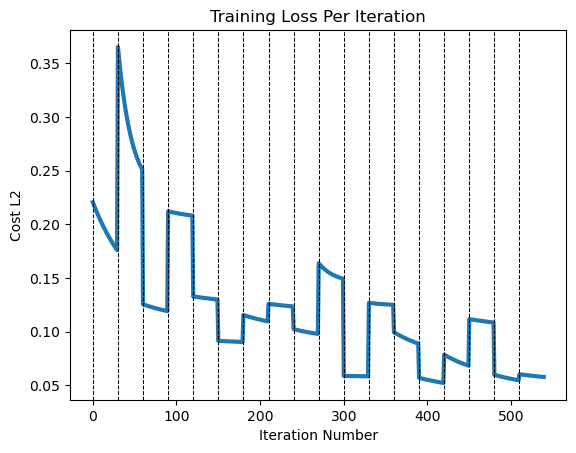

In [6]:
num_input_channels = 64  # Change once I add PCA
input_size = num_input_channels
output_size = 2  # 2D Velocity

learning_rate = 0.0001
# Other option which should give same result:
untrained_model_NoFL = torch.nn.Linear(input_size, output_size)  # Single layer nn for Lin Regr
optimizer = torch.optim.SGD(untrained_model_NoFL.parameters(), lr=learning_rate)

trained_model_NoFL, loss_log_NoFL = full_train_linregr_updates(untrained_model_NoFL, F1tens_full, PREF1tens_full, learning_rate, starting_update=0)

plt.plot(range(len(loss_log_NoFL)), loss_log_NoFL, linewidth=3)
plt.title("Training Loss Per Iteration")
update_advancement_idxs = range(0,num_iters_per_update*(num_updates-1), num_iters_per_update)
for i in update_advancement_idxs:
    plt.axvline(i, linewidth=0.75, linestyle='--', color='black')
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

Manual Version

In [7]:
# Other option which should give same result:

model = torch.nn.Linear(input_size, output_size)  # Single layer nn for Lin Regr
print(f"Shape of linear model weights: {model.weight.shape}")
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_log = []

for update in range(len(update_ix)-1):
    lower_bound = update_ix[update]
    upper_bound = update_ix[update+1]
    
    for i in range(num_iters_per_update):
        if i==0:
            s_temp = F1tens_full[lower_bound:upper_bound]
            p_reference = torch.transpose(PREF1tens_full[lower_bound:upper_bound], 0, 1)
            s = torch.transpose(s_temp, 0, 1)
            
            emg_streamed_batch = s[:,:-1] # F
            v_actual =  torch.matmul(model.weight, s)
            p_actual = torch.cumsum(v_actual, dim=1)/60  # Numerical integration of v_actual to get p_actual
            V = (p_reference - p_actual)/60

            y = p_reference[:, :-1]  # To match the input
            
        # TRAIN MODEL
        # reset gradient so it doesn't accumulate
        optimizer.zero_grad()
        # forward pass and loss
        y_pred = model(torch.transpose(emg_streamed_batch, 0, 1))  # Why do I have to transpose again here... my original code didn't
        # F, D, V, learning_batch
        loss = cost_l2_torch(emg_streamed_batch, model.weight, V, emg_streamed_batch.shape[0])
        # backward pass
        loss.backward(retain_graph=True)
        loss_log.append(loss.item())
        # update weights
        optimizer.step()

Shape of linear model weights: torch.Size([2, 64])


In [8]:
print(num_iters_per_update*(num_updates-1))
update_advancement_idxs = range(0,num_iters_per_update*(num_updates-1), num_iters_per_update)
print(update_advancement_idxs)

540
range(0, 540, 30)


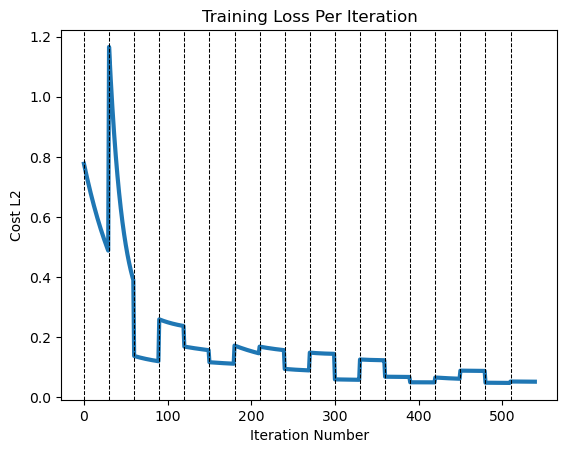

In [9]:
plt.plot(range(len(loss_log)), loss_log, linewidth=3)
plt.title("Training Loss Per Iteration")
for i in update_advancement_idxs:
    plt.axvline(i, linewidth=0.75, linestyle='--', color='black')
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

In [10]:
print(f"Final Loss: {loss_log[-1]}")
print("----- ----- ----- ----- -----")
print("Prediction:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)
        print(param.shape)
        print()

Final Loss: 0.052410367876291275
----- ----- ----- ----- -----
Prediction:
weight
torch.Size([2, 64])

bias
torch.Size([2])



## Redo but with FL Data Processing Turned On

In [11]:
# PARAMS
num_updates = 9
starting_update = 10
normalize_emg = True
pca_channel_default = 64
PCA_comps = 7

# BUILD MODEL
num_input_channels = PCA_comps 
input_size = num_input_channels
# ^ IRL I'm not sure we are guaranteed to get equalength trials
#  Thus may be better to do every time point individually? Not sure
output_size = 2  # 2D Velocity
learning_rate = 0.0001

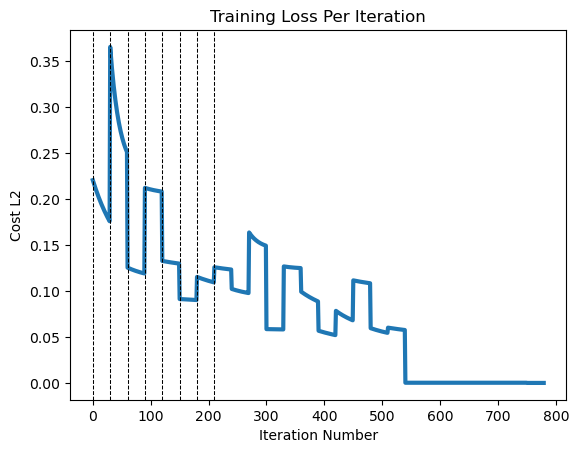

In [12]:
num_input_channels = PCA_comps  # Change once I add PCA
input_size = num_input_channels
output_size = 2  # 2D Velocity

learning_rate = 0.0001
# Other option which should give same result:
untrained_model_FLDP = torch.nn.Linear(input_size, output_size)  # Single layer nn for Lin Regr
optimizer = torch.optim.SGD(untrained_model_FLDP.parameters(), lr=learning_rate)

trained_model_FLDP, loss_log_FLDP = full_train_linregr_updates(untrained_model_FLDP, F1tens_full, PREF1tens_full, learning_rate, starting_update=10, normalize_emg=True, PCA_comps=7)

plt.plot(range(len(loss_log_FLDP)), loss_log_FLDP, linewidth=3)
plt.title("Training Loss Per Iteration")
update_advancement_idxs = range(0,num_iters_per_update*(num_updates-1), num_iters_per_update)
for i in update_advancement_idxs:
    plt.axvline(i, linewidth=0.75, linestyle='--', color='black')
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

# Validation with SKLearn
> Note that using Least Squares, we can solve for the closed-form solution (e.g. don't need to iteratively solve via gradient descent).  However, for the federated case, we can't just use the one-shot closed-form solution since averaging local solutions can perform arbitrarily poorly (...); likewise, each client does not have the full dataset (e.g. all the data in the network) and thus will not solve for the overall solution (only their local solution, which as discussed above, is a poor global solution).

In [13]:
import sklearn.linear_model
linr = sklearn.linear_model.LinearRegression()
linr.fit(torch.transpose(emg_streamed_batch,0,1), torch.transpose(y,0,1))

LinearRegression()

In [14]:
x_segment = torch.transpose(emg_streamed_batch,0,1)#[0:10, :]
y_segment = torch.transpose(y,0,1)#[0:10, :]

criterion = torch.nn.MSELoss()

print(f"Score Loss: {linr.score(x_segment, y_segment)}")
print(f"Criterion Loss: {criterion(torch.tensor(linr.predict(x_segment)), y_segment)}")
print("---------------------------------------------")
print("Prediction:")
print(f"b_pred = {linr.intercept_.shape}")
print(linr.intercept_)
print()
print(f"w_pred = {linr.coef_.shape}")
print(linr.coef_)

Score Loss: 0.9391416462468352
Criterion Loss: 7.460017681121826
---------------------------------------------
Prediction:
b_pred = (2,)
[-76.0198   38.48555]

w_pred = (2, 64)
[[ 5.86571451e-03 -6.57292753e-02 -2.90500283e-01 -8.49985480e-02
   3.05740833e-01  2.77577877e-01  1.55698761e-01 -1.77700430e-01
  -8.87559175e-01 -2.87191197e-03  1.83846831e-01 -3.70656103e-02
   1.44593090e-01  7.91661739e-02 -4.51575369e-02 -3.89595300e-01
   1.97667167e-01  2.01098025e-01  2.03980625e-01 -1.87577039e-01
  -8.01451504e-02  1.40460432e-01 -8.12691748e-02  7.50302374e-02
   8.34825933e-02  1.37546435e-01  1.31685689e-01 -6.47162795e-02
  -6.00545928e-02 -3.52795929e-01  3.49880792e-02  1.24320877e+00
   6.93959296e-02 -3.79447699e-01  4.93756160e-02 -1.44857436e-01
  -3.30365822e-02  1.53366446e-01 -1.09319597e-01  1.37041315e-01
   1.55600458e-01 -4.02456224e-01  2.34094992e-01 -8.15716922e-01
  -3.25036049e-03 -1.19678646e-01  2.41912037e-01 -1.01633966e-01
  -3.72363031e-02 -2.43222415e-